#CNN model for Image classification

This Jupyter Notebook presents the development and evaluation of a Convolutional Neural Network (CNN) model to determine whether an image contains sunglasses. The task involves classifying images into two categories: those containing sunglasses and those without.

#Preprocess

In [ ]:
from matplotlib import image
from matplotlib import pyplot
import numpy as np
from sklearn.model_selection import train_test_split
from keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm, datasets
from keras.layers import ZeroPadding2D
from sklearn.metrics import accuracy_score

##Loading the data

In [ ]:
!wget url_to_the_zip_file
!unzip Faces.zip

In [ ]:
from os import listdir
from os.path import isfile, join
NoSunglasses_file = [f for f in listdir('/content/NoSunglasses') if isfile(join('/content/NoSunglasses', f))]
Sunglasses_file = [f for f in listdir('/content/Sunglassess') if isfile(join('/content/Sunglassess', f))]
NoSunglasses = np.array([image.imread('/content/NoSunglasses/{}'.format(x)) for x in NoSunglasses_file])
Sunglassess = np.array([image.imread('/content/Sunglassess/{}'.format(x)) for x in Sunglasses_file])

##Add labels

In [ ]:
NoSunglasses_len = len(NoSunglasses)
Sunglassess_len = len(Sunglassess)
y_no = [0]*NoSunglasses_len
y_yes = [1]*Sunglassess_len
y = np.array(y_no + y_yes)

In [ ]:
#Concatenate the data
x = np.concatenate((NoSunglasses, Sunglassess))
x.shape = (624, 30, 32, 1)

##Split the data to train, validation and test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.15, random_state=42)

##Take a look at the data

In [ ]:
#Look at the shape of the data
print(f'Number of images in training (test) set: {len(x_train)} ({len(x_test)})')
x_train[0].shape

Number of images in training (test) set: 355 (206)


(30, 32, 1)

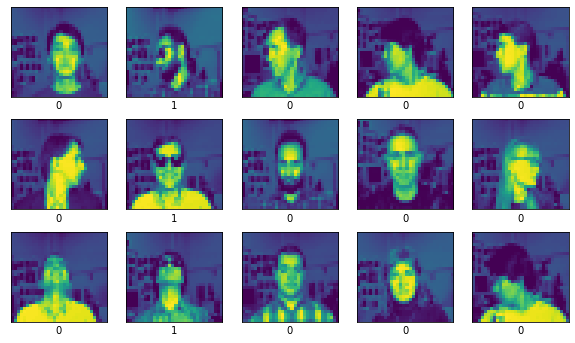

In [ ]:
class_names = [0, 1]

plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = x_train[i]
    img.shape = (img.shape[0], img.shape[1])
    plt.imshow(img)
    plt.xlabel(class_names[int(y_train[i])])
plt.show()

#Define a CNN model:

In [ ]:
def cnn_model(shape, filters = 16, kernel_size = (3,3), pool_size = (2,2), padding = 'same', optimizer = 'adam'):

  # # Create convolutional base
  model = models.Sequential()
  # Inpute shape (image_height, image_width, color_channels)
  # with padding and dense
  model.add(layers.Conv2D(filters = filters,kernel_size =kernel_size, activation='relu', input_shape=shape, padding=padding, name='conv_1'))
  model.add(layers.MaxPooling2D(pool_size))
  model.add(layers.Conv2D(filters = 2*filters,kernel_size =kernel_size, activation='relu', padding=padding, name='conv_2'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(10, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

  return model

In [ ]:
# Defining the grid search parameters
optimizer = ['adam', 'SGD', 'Adagrad', 'Adamax', 'adamw', 'adadelta']
param_grid = dict(shape = [x_train[0].shape], optimizer = optimizer)

#Train the models
Experiment different batch sizes, and optimizers with grid search cross validation:

In [ ]:
max_acc = 0
history_for_batch = {}
for batch in [2, 4, 8]:
  model = KerasClassifier(build_fn=cnn_model, epochs=18, batch_size=batch, verbose=0)
  grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
  grid_result = grid.fit(x_train, y_train, validation_data=(x_validation, y_validation))
  history = grid_result.best_estimator_.model.history.history
  test_loss, test_acc = grid_result.best_estimator_.model.evaluate(x_test,  y_test, verbose=2)
  history_for_batch[batch] = [test_loss, test_acc, history, grid_result.best_params_]

#Examine the performance on the test set

In [ ]:
# [test_loss, test_acc, history, grid_result.best_params_]
for batch, values in history_for_batch.items():
  print(f'-------Batch size = {batch}--------,Test loss = {values[0]}, Test accuracy = {values[1]}')
  print(f'Parametrs: {values[3]}')

-------Batch size = 2--------,Test loss = 0.3036527633666992, Test accuracy = 0.9708737730979919
Parametrs: {'optimizer': 'adam', 'shape': (30, 32, 1)}
-------Batch size = 4--------,Test loss = 0.14536340534687042, Test accuracy = 0.9708737730979919
Parametrs: {'optimizer': 'adam', 'shape': (30, 32, 1)}
-------Batch size = 8--------,Test loss = 0.11154717952013016, Test accuracy = 0.9708737730979919
Parametrs: {'optimizer': 'Adamax', 'shape': (30, 32, 1)}


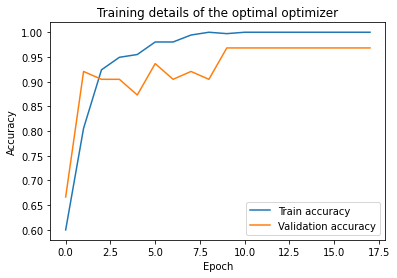

In [ ]:
#All of the batch sizes have the same accuracy - so the best is the one with the smallest loss
best_batch_size = min(history_for_batch, key= lambda x: history_for_batch.get(x)[0])

#Fetch accuracy of train and validation sets
train_acc = history_for_batch[best_batch_size][2]['accuracy']
val_acc = history_for_batch[best_batch_size][2]['val_accuracy']

#plot
plt.plot(train_acc, label='Train accuracy')
plt.plot(val_acc, label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training details of the optimal optimizer")
plt.legend(loc='lower right')

**What's the effect of batch size?**

The batch size effects the weights(model parameters) because our back propagation in actually SGD, meaning that the calclulation of the gradients is excuted only after each batch. This means that when the batch size grows the more samples are beign taken into account for each update of the gradient. On the other hand, for a bigger size of batch there are more computations which may cause slower convergence.

Let's try different batch sizes and have a look at the results:

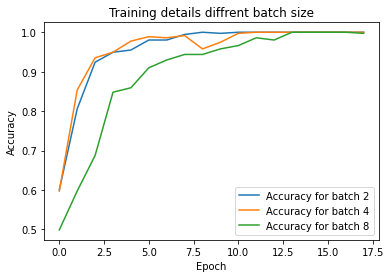

In [ ]:
for batch, hist in history_for_batch.items():
  plt.plot(hist[2]['accuracy'], label=f'Accuracy for batch {batch}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training details diffrent batch size")
plt.legend(loc='best')